In [1]:
import os
import pandas as pd
import re
from textblob import TextBlob
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
matplotlib.font_manager._rebuild()
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)
import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager
font_manager._rebuild()

In [2]:
BASE_URL = 'dataset/'

master_array = []

for filename in os.listdir(BASE_URL):
    
    f = open(BASE_URL+filename, "r", encoding='utf-8')
    
    split_name = filename.split('.') #obtain the season and episodes
    season = split_name[0]   
    episode = split_name[1]
    
    script = f.read() #read the script file
    pattern = re.compile(r'\s(?=\w+(?=:))') # store the regex
    result = re.split(pattern, script) # split the script where our pattern matched (pink dot)
    
    for item in result:
        split_line = item.split(':')
        try:
            character = split_line[0]
            speech = split_line[1]
            master_array.append([season, episode, character, speech])
        except:
            pass

In [3]:
df = pd.DataFrame(master_array, columns=['season', 'episode', 'char', 'line'])
df

,season,episode,char,line
0,1,1,by,Marta Kauffman & David Crane\nTranscribed
1,1,1,by,guineapig\nAdditional transcribing
2,1,1,by,Eric Aasen\n(Note
3,1,1,Monica,There's nothing to tell! He's just some guy\n...
4,1,1,Joey,"C'mon, you're going out with the guy! There's..."
...,...,...,...,...
61845,9,9,Scene,Central Perk.� Phoebe and Mike are on the sof...
61846,9,9,ROSS,Hey you guys.� (He sits.)
61847,9,9,MIKE,Hey.
61848,9,9,PHOEBE,Hey.� I'll be right back.� I've got to go to ...


#### Droping all of these rows by removing the character 'by'

In [4]:
df = df[df.char != 'by']
df

,season,episode,char,line
3,1,1,Monica,There's nothing to tell! He's just some guy\n...
4,1,1,Joey,"C'mon, you're going out with the guy! There's..."
5,1,1,Chandler,"All right Joey, be\nnice. So does he have a ..."
6,1,1,Phoebe,"Wait, does he eat chalk?\n(They all stare, be..."
7,1,1,Phoebe,"Just, 'cause, I don't want her to go through\..."
...,...,...,...,...
61845,9,9,Scene,Central Perk.� Phoebe and Mike are on the sof...
61846,9,9,ROSS,Hey you guys.� (He sits.)
61847,9,9,MIKE,Hey.
61848,9,9,PHOEBE,Hey.� I'll be right back.� I've got to go to ...


In [5]:
df['char'].unique()[20:30]

array(['Bobby', 'Clark', 'Street', 'Guy', 'Leno', 'Paolo', 'Bing',
       'Carol', 'Susan', 'Assistant'], dtype=object)

In [6]:
df['char'].replace({'Chandler':'Chandler','CHANDLER':'Chandler', 'Chandlers':'Chandler', 'chandler': 'Chandler',
                    'Joey':'Joey', 'JOEY': 'Joey',
                    'Monica':'Monica','MONICA':'Monica', 'MOnica': 'Monica', 'MNCA': 'Monica',
                    'Phoebe':'Phoebe','PHOEBE':'Phoebe', 'Pheebs':'Phoebe', 'Pheebs':'Phoebe',
                    'Rachel':'Rachel','RACHEL':'Rachel', 'RACH':'Rachel', 'RAHCEL':'Rachel', 'Racel':'Rachel', 'Rache':'Rachel',
                    'Ross':'Ross', 'RUSS':'Ross', 'ROSS': 'Ross'}, inplace=True)

In [7]:
char = ['Chandler', 'Joey', 'Monica', 'Phoebe', 'Rachel', 'Ross']
df = df[df['char'].isin(char)]

In [8]:
df

,season,episode,char,line
3,1,1,Monica,There's nothing to tell! He's just some guy\n...
4,1,1,Joey,"C'mon, you're going out with the guy! There's..."
5,1,1,Chandler,"All right Joey, be\nnice. So does he have a ..."
6,1,1,Phoebe,"Wait, does he eat chalk?\n(They all stare, be..."
7,1,1,Phoebe,"Just, 'cause, I don't want her to go through\..."
...,...,...,...,...
61842,9,9,Ross,"(holds up the message) Uh, Rach."
61843,9,9,Rachel,(still looking at Emma) Yeah?
61844,9,9,Ross,"(pauses, then crunches up the note and stuffs..."
61846,9,9,Ross,Hey you guys.� (He sits.)


In [9]:
df['sentiment'] = df['line'].apply(lambda x: TextBlob(x).sentiment[0])

In [10]:
df['season'] = df['season'].apply(lambda x: int(x))
df['episode'] = df['episode'].apply(lambda x: int(x))

In [11]:
conn = sqlite3.connect('friends_script.db') #connect to the database
cur = conn.cursor()
cur.execute('CREATE TABLE IF NOT EXISTS Friends(season number, episode number, char text, line text, sentiment integer)')
conn.commit()

In [12]:
df.to_sql('Friends', conn, if_exists='replace', index=False) # save into the 'lines' table

In [13]:
COLORS=['#40E0D0', '#4682B4', '#708090', '#90EE90', '#FFDEAD', '#E9967A']

## The Most Popular Friend

In [14]:
cur.execute("SELECT char, COUNT(line) AS 'spoken_lines' FROM Friends GROUP BY char ORDER BY spoken_lines DESC")
most_lines = [c for c in cur.fetchall()]

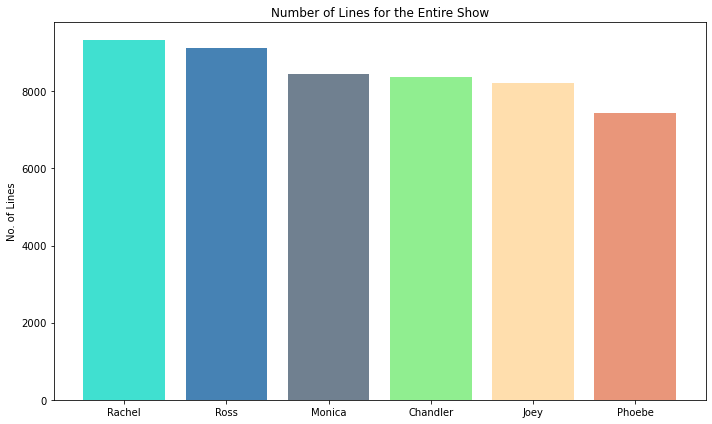

In [15]:
plt.rcParams['figure.figsize'] = (10, 6)
fig, ax = plt.subplots()
plt.bar(
    x=[line[0] for line in most_lines],
    height=[line[1] for line in most_lines],
    color=COLORS
)
plt.title('Number of Lines for the Entire Show')
plt.ylabel('No. of Lines')
fig.tight_layout()

## Number of lines per season

In [16]:
cur.execute("""
SELECT char, season, count(line) AS total_lines FROM Friends 
WHERE char IN ('Rachel', 'Ross', 'Monica','Chandler','Joey', 'Phoebe') GROUP BY season, char""")
lines_per_season = [c for c in cur.fetchall()]

In [17]:
lines_dict = {}
for lines in lines_per_season:
    char = lines[0]
    season = lines[1]
    total_lines = lines[2]
    
    if char in lines_dict:
        # append the new number to the existing array at this slot
        lines_dict[char][season] = total_lines
    else:
        # create a new array in this slot
        lines_dict[char] = {
            season: total_lines
        }

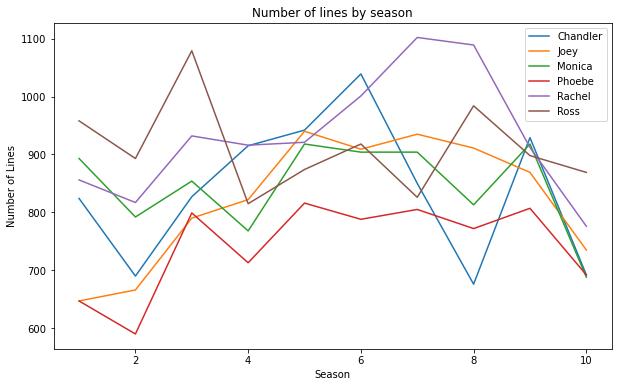

In [18]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (10, 8)
for char in lines_dict.keys():
    x1 = lines_dict[char].keys()
    y1 = lines_dict[char].values()
    plt.plot(x1, y1, label = char)
    
plt.xlabel('Season')
plt.ylabel('Number of Lines')
plt.title('Number of lines by season')
plt.legend(loc=1)
plt.show()

### Most Spoken About


In [19]:
nicknames = [['Rachel', 'Rach'], 
             ['Ross', 'Ross-A-Tron', 'Professor Geller'], 
             ['Monica', 'Mon'],
             ['Chandler', 'Chan'],
             ['Joey', 'Joe'], 
             ['Phoebe', 'Phoebes']]

In [20]:
all_lines = pd.read_sql("SELECT line FROM Friends", conn)

In [21]:
char_mention = [] 

for name_list in nicknames:    # loop for each character
    mention_counter = 0        # keep track of the mentions
    for name in name_list:     # loop for each nickname
        mentions = all_lines['line'].str.count(name).sum()
        mention_counter += mentions
    char_mention.append([name_list[0], mention_counter]) #append the name and mention count

In [22]:
char_mention = sorted(char_mention, key=lambda x: x[1], reverse=True)

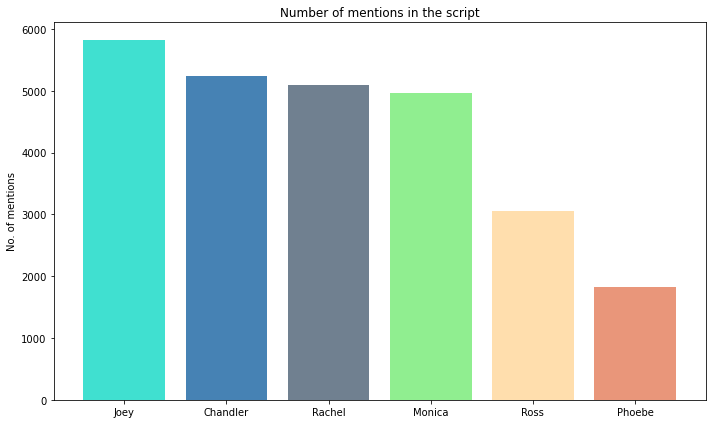

In [23]:
plt.rcParams['figure.figsize'] = (10, 6)
fig, ax = plt.subplots()
plt.bar(
    x=[mention[0] for mention in char_mention],
    height=[mention[1] for mention in char_mention],
    color=COLORS
)
plt.title('Number of mentions in the script')
plt.ylabel('No. of mentions')
fig.tight_layout()

### Largest Vocabulary

In [24]:
# function to remove all non alphabetical characters keep spaces
def alphanumonly(text):
    '''Remove all non letters from string'''
    regex = re.compile('[^a-zA-Z ]')
    #First parameter is the replacement, second parameter is your input string
    return(regex.sub('', text))

In [25]:
cur.execute("SELECT char, line FROM Friends WHERE char IN ('Rachel', 'Ross', 'Monica','Chandler','Joey', 'Phoebe')")
lines_per_season = [c for c in cur.fetchall()]

In [26]:
monica_vocab = set()
chandler_vocab = set()
ross_vocab = set()
phoebe_vocab = set()
rachel_vocab = set()
joey_vocab = set()

for l in lines_per_season:
    char = l[0]
    l = alphanumonly(l[1]).strip()
    split_words = l.split(' ')
    for word in split_words:
        if char == 'Monica':
            monica_vocab.add(word)
            
        if char == 'Joey':
            joey_vocab.add(word)
        
        if char == 'Ross':
            ross_vocab.add(word)
        
        if char == 'Phoebe':
            phoebe_vocab.add(word)
        
        if char == 'Chandler':
            chandler_vocab.add(word)
        
        if char == 'Rachel':
            rachel_vocab.add(word)

char_vocal_length = ['Ross', 'Joey', 'Chandler', 'Rachel', 'Phoebe', 'Monica']
vocab_lengths = [len(ross_vocab), len(joey_vocab), len(chandler_vocab), len(rachel_vocab), len(phoebe_vocab), len(monica_vocab)]

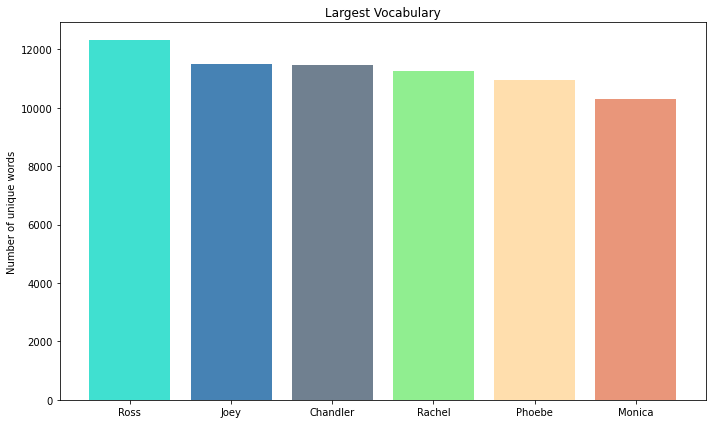

In [27]:
plt.rcParams['figure.figsize'] = (10, 6)
fig, ax = plt.subplots()
plt.bar(
    x=char_vocal_length,
    height=vocab_lengths,
    color=COLORS
)
plt.title('Largest Vocabulary')
plt.ylabel('Number of unique words')
fig.tight_layout()

## Ross and Rachel Sentiments throughout the season

In [28]:
cur.execute("SELECT season, episode, sentiment FROM Friends WHERE char == 'Ross' ORDER BY season, episode")
ross_sentiments = [c for c in cur.fetchall()]

In [29]:
ross_sentiment = {}

for r in ross_sentiments:
    season_episode = f'S{r[0]}E{r[1]}'
    if r[0] == 10:
        season_episode = f'STENE{r[1]}'
    sentiment = r[2]
    if season_episode in ross_sentiment:
        ross_sentiment[season_episode] += sentiment
    else:
        ross_sentiment[season_episode] = sentiment

In [30]:
plt.rcParams['figure.figsize'] = (14, 5)

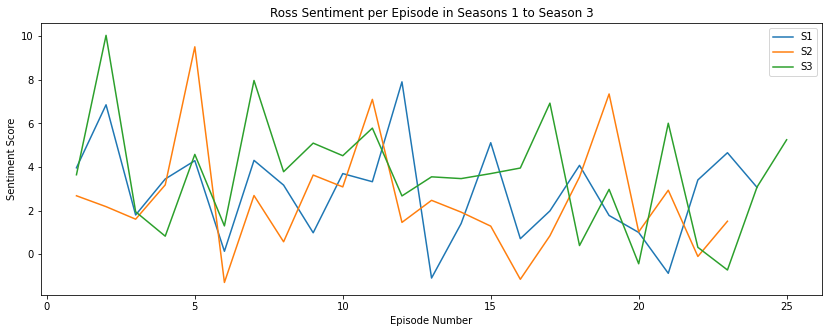

In [31]:
seasons = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'STEN']
for season in seasons[0:3]:
    sentiments = list(filter(lambda item: item[0].startswith(season), ross_sentiment.items())) 
    x1 = list(range(1, len(sentiments)+1))
    y1 = [x[1] for x in sentiments]
    plt.plot(x1, y1, label = season)
    
plt.xlabel('Episode Number')
plt.ylabel('Sentiment Score')
plt.title('Ross Sentiment per Episode in Seasons 1 to Season 3')
plt.legend(loc=1)
plt.show()

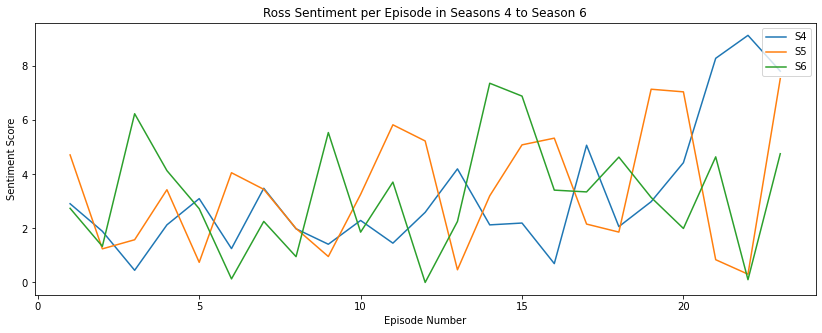

In [32]:
for season in seasons[3:6]:
    sentiments = list(filter(lambda item: item[0].startswith(season), ross_sentiment.items())) 
    x1 = list(range(1, len(sentiments)+1))
    y1 = [x[1] for x in sentiments]
    plt.plot(x1, y1, label = season)
    
plt.xlabel('Episode Number')
plt.ylabel('Sentiment Score')
plt.title('Ross Sentiment per Episode in Seasons 4 to Season 6')
plt.legend(loc=1)
plt.show()

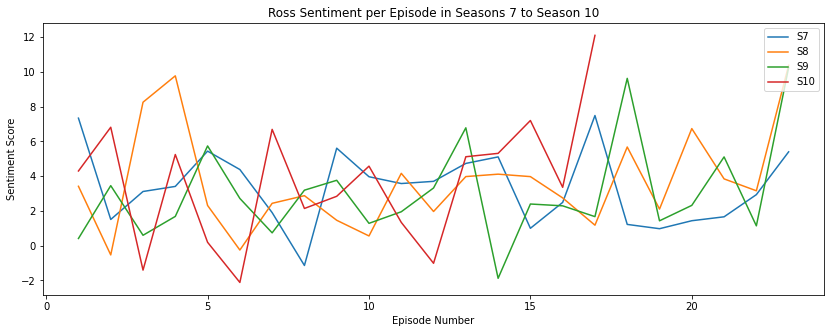

In [33]:
for season in seasons[6:]:
    
    sentiments = list(filter(lambda item: item[0].startswith(season), ross_sentiment.items())) 
    x1 = list(range(1, len(sentiments)+1))
    y1 = [x[1] for x in sentiments]
    
    if season == 'STEN': season = 'S10'
    plt.plot(x1, y1, label = season)
    
plt.xlabel('Episode Number')
plt.ylabel('Sentiment Score')
plt.title('Ross Sentiment per Episode in Seasons 7 to Season 10')
plt.legend(loc=1)
plt.show()